# Classifying Cardiovascular Diseases in a Simple Way!

### Introduction

Cardiovascular diseases (CVDs) collectively describe a group of disorders involving the heart and the blood vessels surrounding it. CVDs correlate with age, hereditary diseases (ex. type 2 diabetes, thalassemia), and with unhealthy behaviors such as smoking, little physical exercise, and excessive alcohol consumption. Research in CVDs have been a great deal of interest as it is estimated that 17.9 million lives are claimed by CVDs annually worldwide. 

Common tests to diagnose CVDs include blood work, electrocardiogram, ambulatory monitoring, cardiac CTs and MRIs, and stress tests. However, an accurate diagnosis still requires much manual analysis integrating laboratory results and patient information. Thus, manual diagnosis can be complex and time consuming while depending on the physicians' knowledge and experience. 

The accuracy for diagnosing CVDs could suffer even further in facilities with limited resources. One can imagine that a lack of diagnostic machines, staff, and medical experience could result in poorer correct diagnosis of heart patients. Here, we explore whether a classifier that consumes simple predictors (gathered without advanced machineries and high medical experience) could accurately predict the presence of cardiovascular diseases in patients.

The datasets which we will use to develop our AI model are taken from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Heart+Disease). The data was collected from patients in the following locations:

1. Cleveland Clinic Foundation
2. Hungarian Institute of Cardiology, Budapest
3. V.A. Medical Center, Long Beach, CA
4. University Hospital, Zurich, Switzerland

Each location compiled a separate database that contains 76 recorded attributes for each individual in their list of heart patients. For our purposes, we are going to focus on a subset of 7 attributes from a combined dataset from all four locations. The 7 attributes are as follows:

1. `age` - age of patients
2. `sex` - sex of patients
3. `exang` - presence of exercised induced angina (Yes / No). Angina is a type of chest pain caused by reduced blood flow to the heart.
4. `oldpeak` - an electrocardiogram measurement (ST depression induced by exercise relative to rest).
5. `slope` - an electrocardiogram measurement (slope of the peak exercise ST segment).
6. `thal` - presence of thalassemia (no presence, fixed defect, reversable defect), an inherited blood disorder that causes your body to have less hemoglobin than normal. 
7. `num` - categorization of the severity of CVD in 0 to 4, with "0" being free of CVD.

In [1]:
#Loading Packages
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

#Loading the Data
cleveland <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)
hungarian <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", col_names = FALSE)
switzerland <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", col_names = FALSE)
va <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data", col_names = FALSE)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Wrangling and Tidying Data

In [2]:
#Adding an origin category for each row
cleveland_data <- mutate(cleveland, Origin = "cleveland")
hungarian_data <- mutate(hungarian, Origin = "hungarian")
switzerland_data <- mutate(switzerland, Origin = "switzerland")
va_data <- mutate(va, Origin = "longbeach")

#Combining the data into a mega data set
mega <- rbind(cleveland_data, hungarian_data, switzerland_data, va_data)

#Adding names to each column
column_names = c("age", "sex", "X3", "X4", "X5", "X6", "X7", "X8", "exercise_induced_angina", "st_depression", "st_segment_slope", "X12", "thalassemia", "presence_of_cvd", "origin")
colnames(mega) <- column_names

#Selecting the columns of interest
mega_data <- mega |> select(age, sex, exercise_induced_angina, st_depression, st_segment_slope, thalassemia, presence_of_cvd, origin)

#Removing all rows that with at least one missing variable in any column.
tidy_data <- mega_data |> filter(exercise_induced_angina != "?" & st_depression != "?" & st_segment_slope != "?" & thalassemia != "?")

#Combining heart severity levels 1 to 4 into one measurement and converting variables in presence_of_cvd into "Yes" or "No"
severity_1_to_4 <- tidy_data |> filter(presence_of_cvd != 0) |> mutate(presence_of_cvd = "Yes")
tidy_data_1 <- tidy_data |> filter(presence_of_cvd == 0) |> mutate(presence_of_cvd = "No") |> rbind(severity_1_to_4)

#Converting variables in sex into "M" or "F"
males <- tidy_data_1 |> filter(sex != 0) |> mutate(sex = "M")
tidy_data_2 <- tidy_data_1 |> filter(sex == 0) |> mutate(sex = "F") |> rbind(males)

#Converting variables in exercise_induced_angina into "No" or "Yes"
not_induced <- tidy_data_2 |> filter(exercise_induced_angina == 0) |> mutate(exercise_induced_angina = "No")
tidy_data_3 <- tidy_data_2 |> filter(exercise_induced_angina == 1) |> mutate(exercise_induced_angina = "Yes") |> rbind(not_induced)

#Converting  variables in thalassemia into more intuitive variables
tidy_data_3 <- tidy_data_3 |> mutate(thalassemia = as.character(thalassemia))
no_presence <- tidy_data_3 |> filter(thalassemia == "3" | thalassemia == "3.0") |> mutate(thalassemia = "No Presence")
fixed_defect <- tidy_data_3 |> filter(thalassemia == "6" | thalassemia == "6.0") |> mutate(thalassemia = "Fixed Defect")
tidy_data_final <- tidy_data_3 |> filter(thalassemia == "7" | thalassemia == "7.0") |> mutate(thalassemia = "Reversable Defect") |> rbind(no_presence, fixed_defect)

glimpse(tidy_data_final)

Rows: 385
Columns: 8
$ age                     <dbl> 51, 61, 43, 56, 56, 66, 55, 57, 58, 64, 40, 51…
$ sex                     <chr> "F", "F", "F", "F", "F", "F", "F", "F", "F", "…
$ exercise_induced_angina <chr> "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes…
$ st_depression           <chr> "1.2", "1", "3", "4", "1.9", "1", "2", "0.2", …
$ st_segment_slope        <chr> "2", "2", "2", "3", "2", "2", "2", "2", "2", "…
$ thalassemia             <chr> "Reversable Defect", "Reversable Defect", "Rev…
$ presence_of_cvd         <chr> "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes…
$ origin                  <chr> "cleveland", "cleveland", "cleveland", "clevel…


In [3]:
#Creating training and testing data set. We decided on a 75-25 split and give the majority set as the training set to ensure 
set.seed(1)
split_data <- initial_split(tidy_data_final, prop = 0.75, strata = presence_of_cvd)
training_data <- training(split_data)
testing_data <- testing(split_data)

### Preliminary Exploratory Data Analysis

In [4]:
#Summary of number of rows in the mega data set, tidied data set, deleted rows from mega data set to create tidied data set, and training data set.
nrows_in_raw_data <- nrow(mega_data)
nrows_in_tidy_data <- nrow(tidy_data_final)
nrows_in_training <- nrow(training_data)
nrows_in_testing <- nrow(testing_data)
raw_stats <- data.frame(nrows_in_raw_data, nrows_in_tidy_data, nrows_in_training, nrows_in_testing) |> 
    mutate(nrows_with_missing_data = nrows_in_raw_data - nrows_in_tidy_data) |>
    select(nrows_in_raw_data, nrows_with_missing_data, nrows_in_tidy_data, nrows_in_training, nrows_in_testing)
raw_stats 

#Summary of patients with CVD in training data set
training_stats <- training_data |> 
    group_by(presence_of_cvd) |> 
    count() |> 
    pivot_wider(names_from = presence_of_cvd, values_from = n) |> 
    rename(CVD_true = No, CVD_false = Yes) |> 
    mutate(total_count = nrows_in_training)
training_stats

#Summary of presence of CVD in training data grouped by patient origins
summary <- training_data |> 
    group_by(origin, presence_of_cvd) |> 
    count() |> 
    pivot_wider(names_from = presence_of_cvd, values_from = n) |> 
    rename(CVD_true_in_training = No, CVD_false_in_training = Yes)
summary

nrows_in_raw_data,nrows_with_missing_data,nrows_in_tidy_data,nrows_in_training,nrows_in_testing
<int>,<int>,<int>,<int>,<int>
920,535,385,288,97


CVD_true,CVD_false,total_count
<int>,<int>,<int>
128,160,288


origin,CVD_true_in_training,CVD_false_in_training
<chr>,<int>,<int>
cleveland,122,107
hungarian,4,4
longbeach,1,10
switzerland,1,39


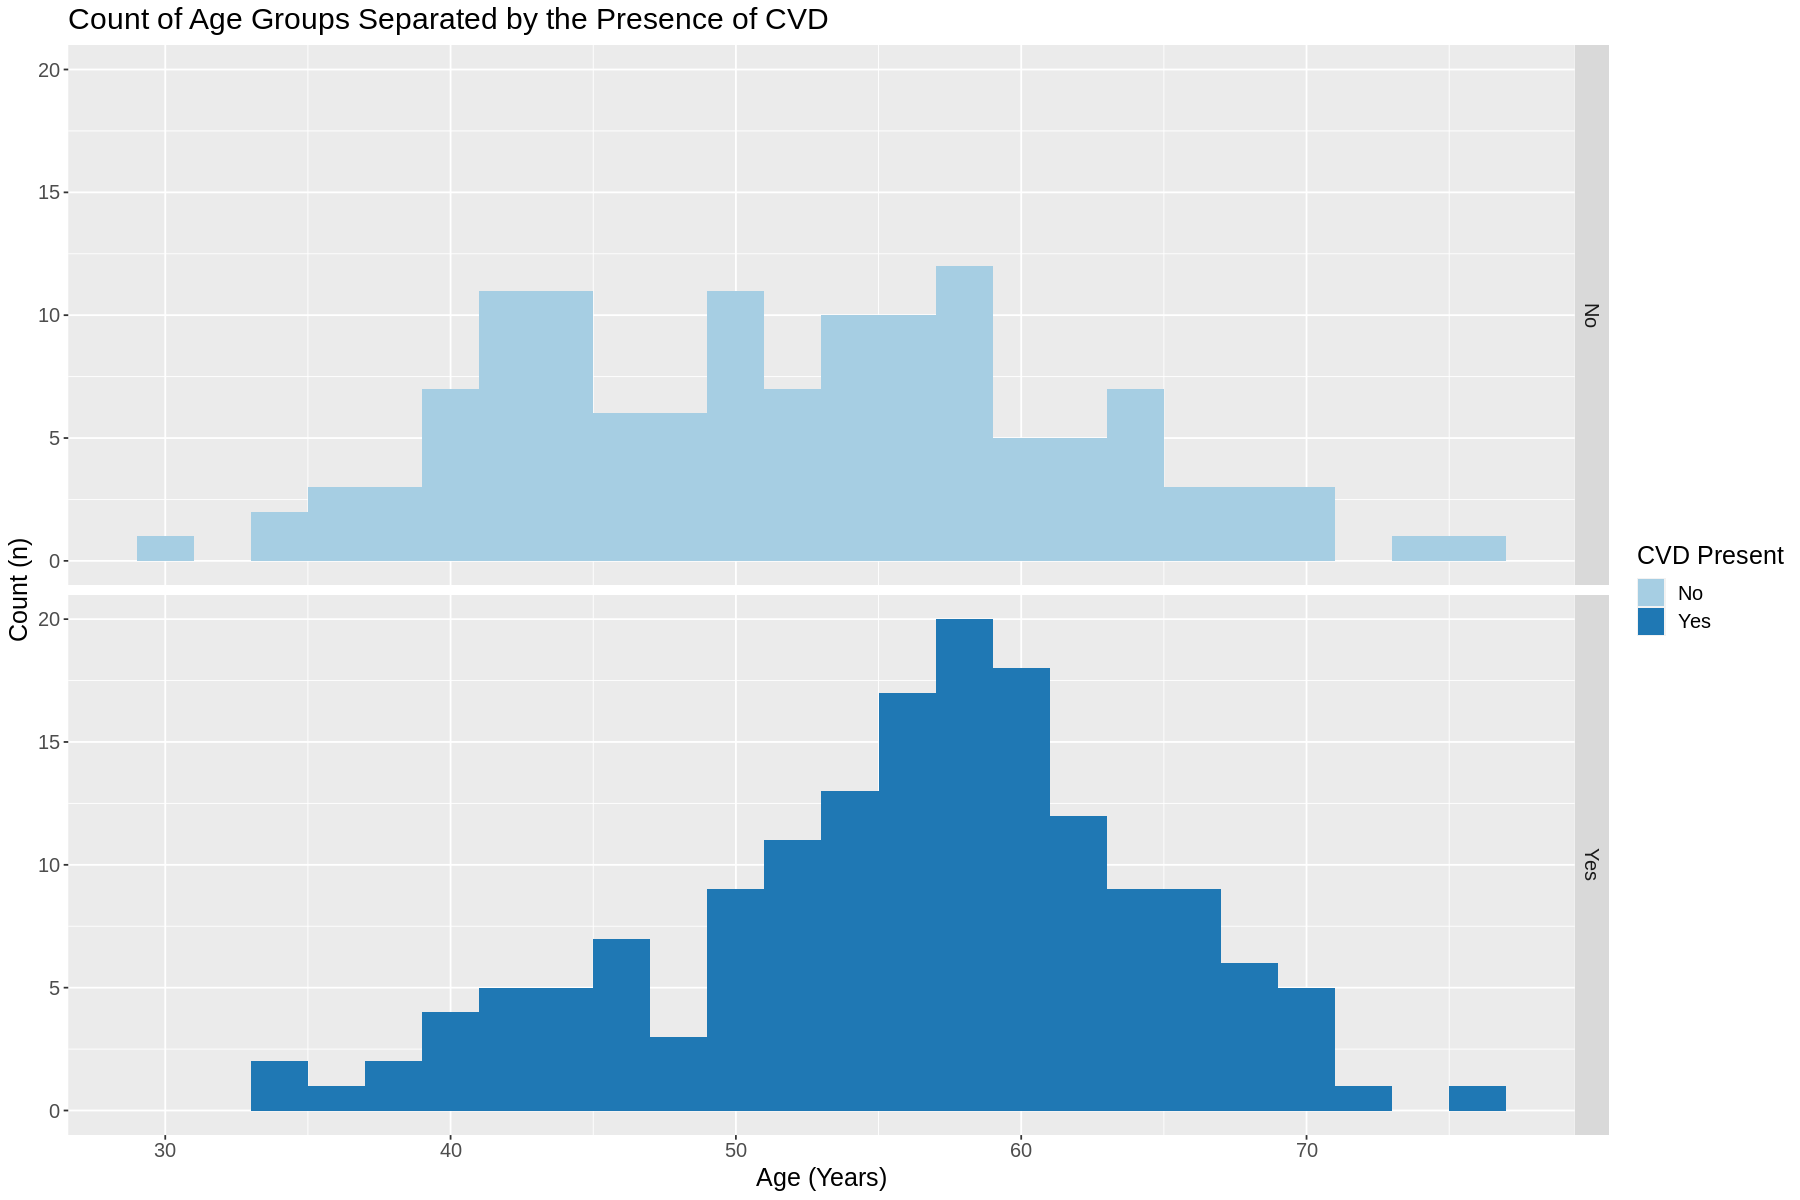

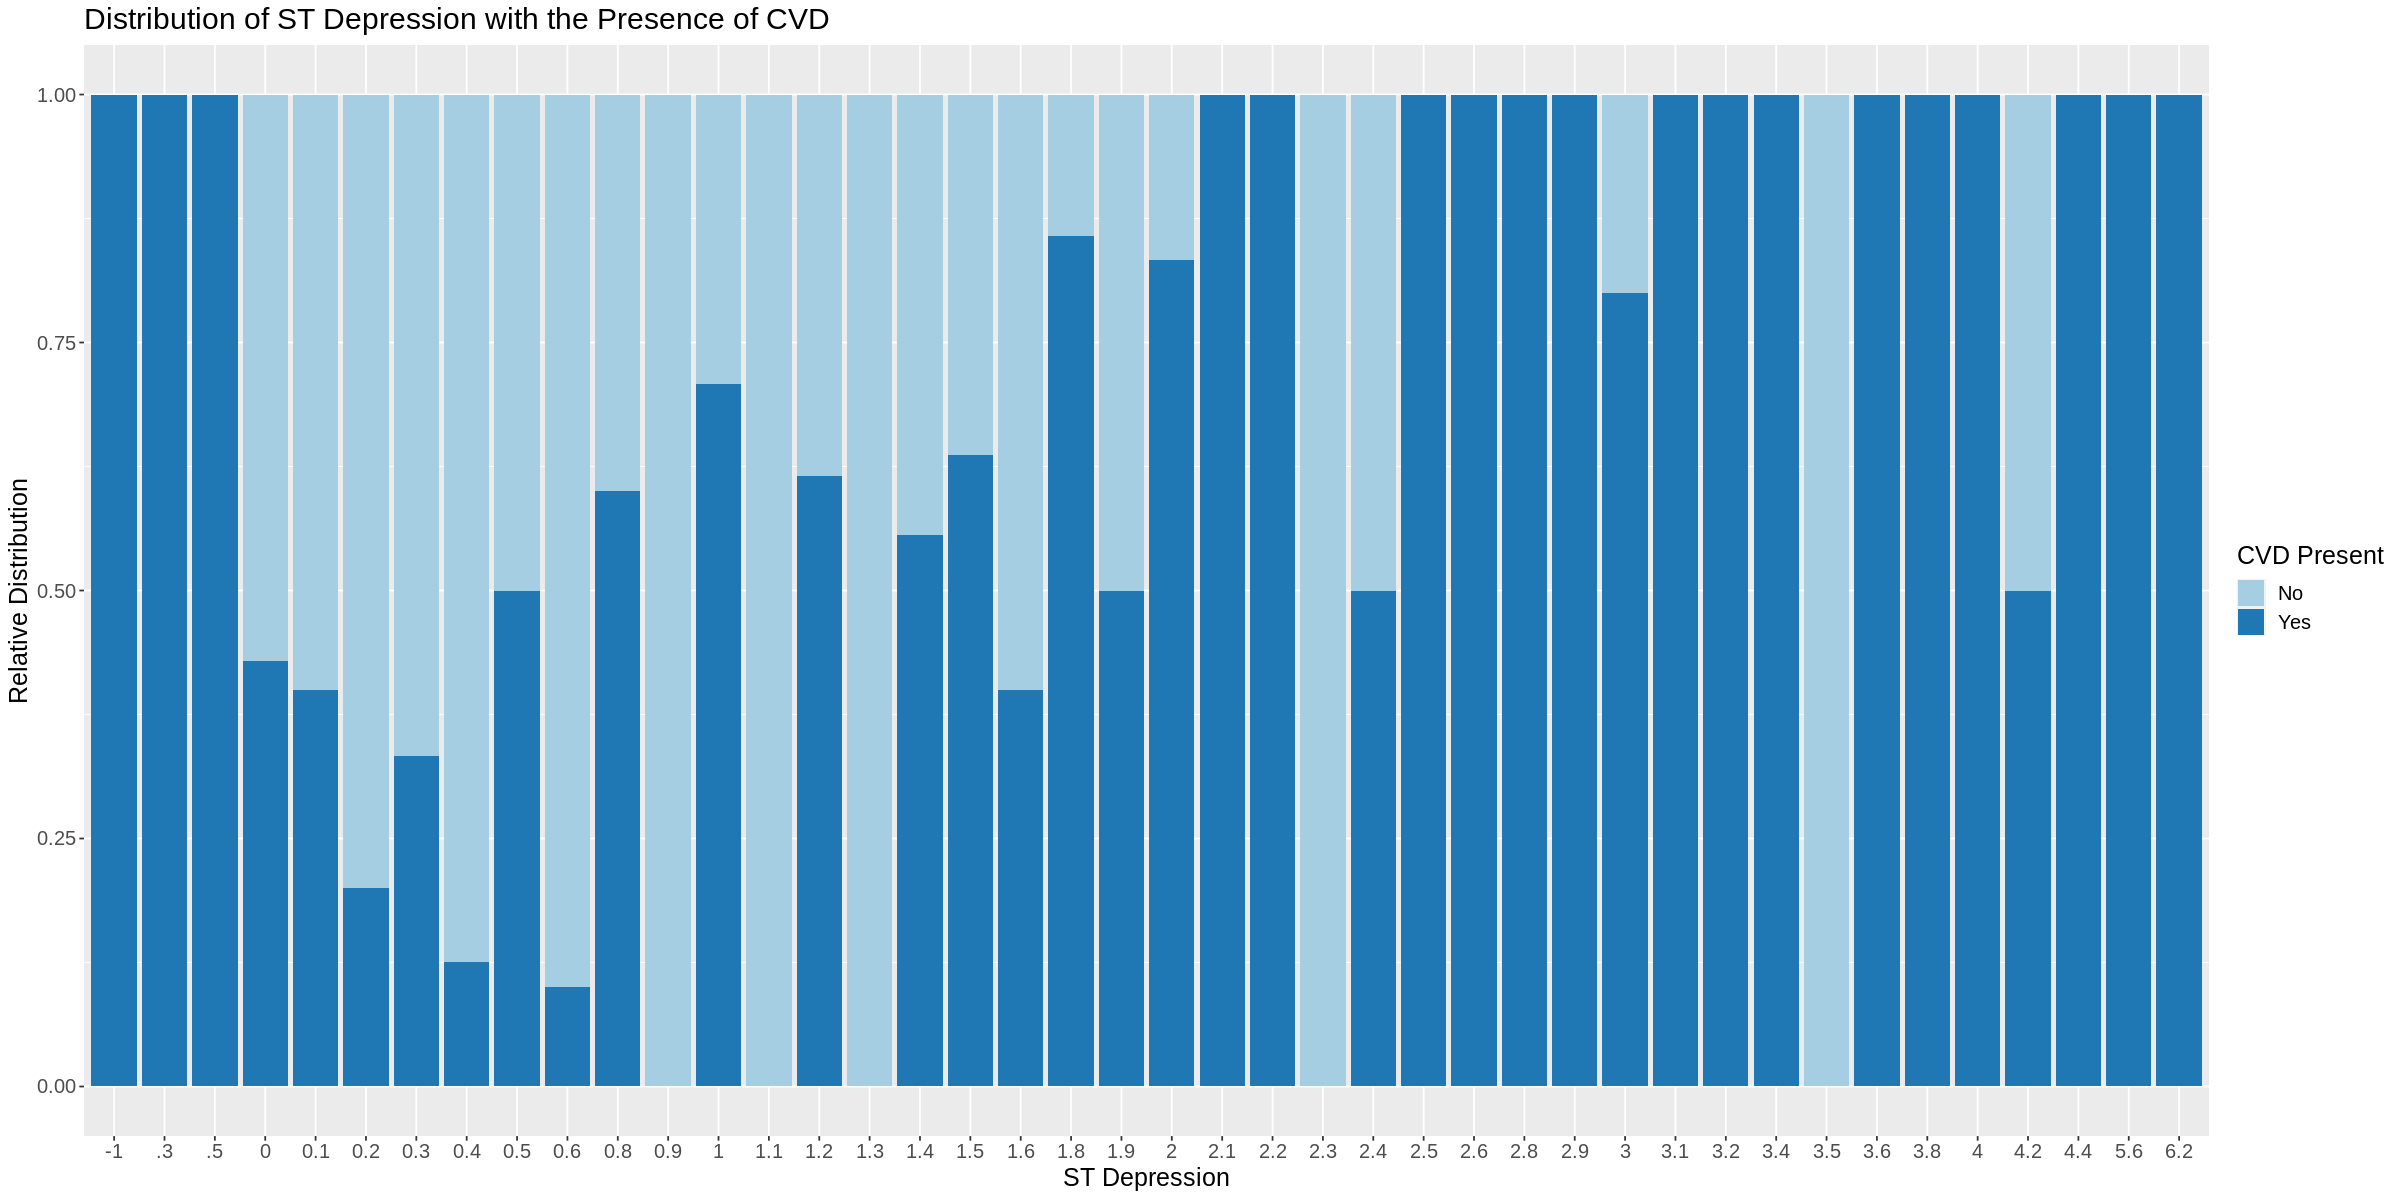

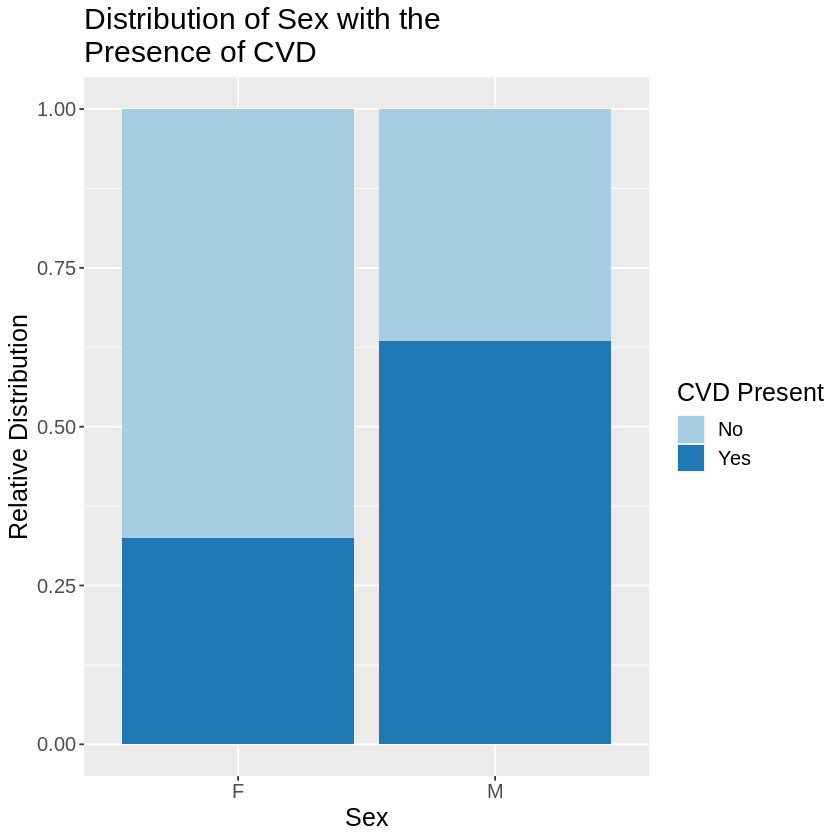

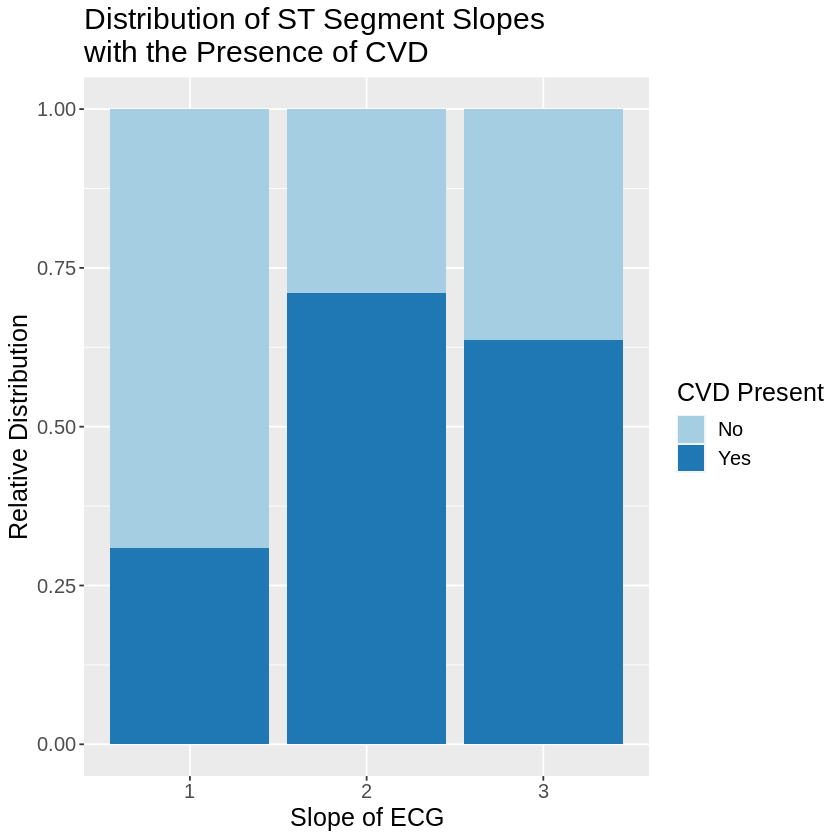

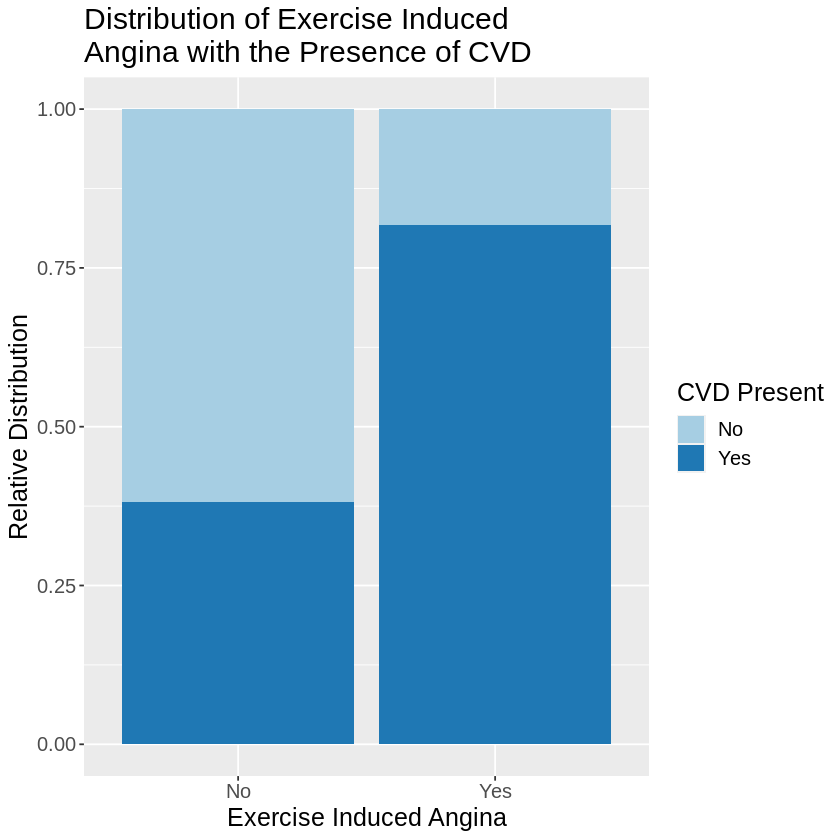

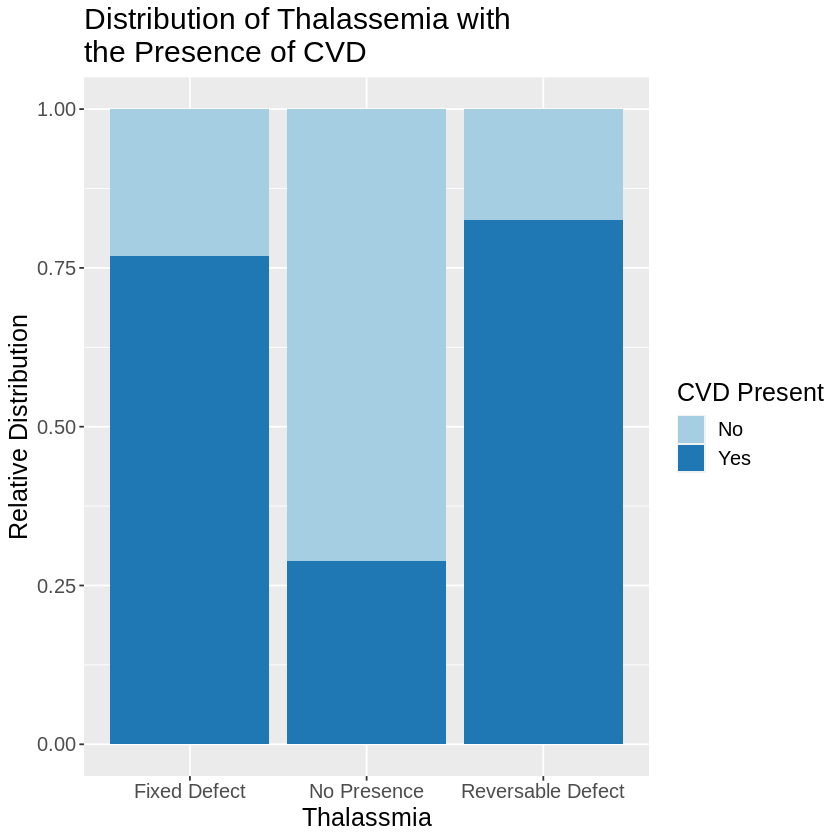

In [6]:
#Age versus presence of CVD. Here we see that Age correlates with the presence of CVD.
options(repr.plot.width = 15, repr.plot.height = 10)
age_vs_pred <- training_data |>
    ggplot(aes(x = age, fill = as_factor(presence_of_cvd))) +
    geom_histogram(bins = 25) + 
    labs(x = "Age (Years)", y = "Count (n)", fill = "CVD Present") + theme(text = element_text(size = 15)) +
    ggtitle("Count of Age Groups Separated by the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired') +
    facet_grid(rows = vars(presence_of_cvd))
age_vs_pred

#ST depression versus presence of CVD. Here we see that there is a certain range of ST depression (0.5 to 1.8) that has the least presence of CVD.
options(repr.plot.width = 20, repr.plot.height = 10)
st_depression_plot <- ggplot(training_data, aes(x = st_depression, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "ST Depression", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 15)) +
    ggtitle("Distribution of ST Depression with the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
st_depression_plot

#Sex versus presence of CVD. Here we see that the relative presence of CVD is different for each sex.
options(repr.plot.width = 7, repr.plot.height = 7)
sex_plot <- ggplot(training_data, aes(x = sex, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "Sex", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 15)) +
    ggtitle("Distribution of Sex with the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
sex_plot

#ST slope versus presence of CVD. Here we see that slope > 1 have increased presence of CVD.
st_segment_slope_plot <- ggplot(training_data, aes(x = st_segment_slope, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "Slope of ECG", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 15)) +
    ggtitle("Distribution of ST Segment Slopes with the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
st_segment_slope_plot

#Exercise induced angina versus presence of CVD. Here we see that presence of exercise induced angina has a significantly higher presence of CVD.
exercise_induced_angina_plot <- ggplot(training_data, aes(x = exercise_induced_angina, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "Exercise Induced Angina", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 15)) +
    ggtitle("Distribution of Exercise Induced Angina with the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
exercise_induced_angina_plot

#Thalassemia versus presence of CVD. Here we see that the presence of any form of thalassemia correlates with higher presence of CVD.
thalassemia_plot <- ggplot(training_data, aes(x = thalassemia, fill = as_factor(presence_of_cvd))) +
    geom_bar(position = "fill") + 
    labs(x = "Thalassmia", y = "Relative Distribution", fill = "CVD Present") + theme(text = element_text(size = 15)) +
    ggtitle("Distribution of Thalassemia with the Presence of CVD") +
    scale_fill_brewer(palette = 'Paired')
thalassemia_plot

### Methodology

The classifier we'll build will be a classification model using K-Nearest Neighbors (KNN). We will use all the columns in our tidied data set (except for the predicted vector) as our predictors. The best way to visualize the accuracy of classifier would be by producing a confusion matrix. From the confusion matrix we would be able to calculate values such as proportions of true/false positives and negatives.

### Expected Outcomes and Significance

We expect our classifier to have a significantly higher accuracy than the baseline of our majority classifier (>55%).

If our classifier is quite accurate, then our model could have practical uses in facilities that lack sophisticated machines, have low physician-to-patient ratios, and shortage of specialized medical expertise. A simple diagnostic circuit (that outputs a value for each of our predictor vectors) could be implemented in medicial facilities. CVDs would be more efficiently detected, and patients could have their conditions treated sooner.

Developing our classifier, we could run into future issues such as deciding on which K values to use, number of vfolds, whether to add more predictor variables, or even consider if such a classifier would be limited in its accuracy.